# Correlations with the Climate indices <br>

This notebook computes the correlations between the climate indices: MEIv2, PDO, NPGO and the fraction of extremse

In [1]:
import xarray as xr
import dask
import glob
import matplotlib.pyplot as plt
import numpy as np
from scipy import integrate
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from statsmodels.tsa.stattools import acf
import scipy.stats as ss
import seaborn as sns
import matplotlib
import datetime
import pickle
import pandas as pd
import itertools
from mpl_toolkits.axes_grid1.inset_locator import inset_axes


colors =itertools.cycle(plt.get_cmap('magma')(np.linspace(0.25,0.75, 3)))
colorA=next(colors)

colorC=next(colors)
colorB=next(colors)
#import basemap
#fig sizes
Wf=(190/25.4)
Hf=(230/25.4)
Wf4=(95/25.4)
Hf4=(115/25.4)

color1='#00CD6C'#green
color2='#AF58BA'#purple
color3='#FFC61E' #yello
color4='#009ADE' #blue
color5='#F28522' #orange
color6='#A0B1BA' #gray
color7='#A6761D'#brown
color8='#FF1F5B' #red

In [2]:
print(sns.__version__)
#mymap=sns.choose_diverging_palette(as_cmap=False)
mymap=sns.choose_colorbrewer_palette('diverging', as_cmap=False)


0.13.1


interactive(children=(Dropdown(description='name', options=('RdBu', 'RdGy', 'PRGn', 'PiYG', 'BrBG', 'RdYlBu', …

In [3]:
cluster_data_path = '/home/amh001/space_fs7/DATA/NEP36-CanOE/'
clusters_ds=[]
for ii in range(6):
    cluster_files = sorted(glob.glob(f'{cluster_data_path}/From_Andrew/processed/daily/by_year/by_cluster/n_clusters_6/cluster_{ii}*.nc')) 
    #print(cluster_files    )
    cluster_ds =xr.open_mfdataset(cluster_files, chunks={'time':439}, engine='h5netcdf')
    clusters_ds.append(cluster_ds)

In [4]:
hist_kwargs = {
    'alpha':1,
    'density':True,
    'bins':25,
    'edgecolor':'None'
}

In [5]:
plot_clusters = [3, 0]
cluster_names = {3:'Shallows', 0:'Canyons'}

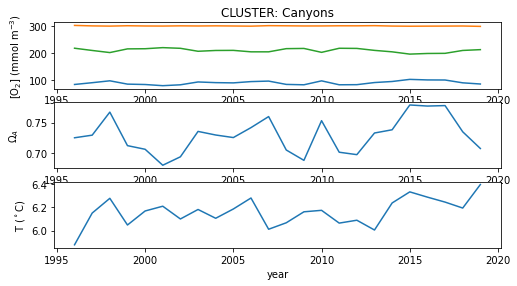

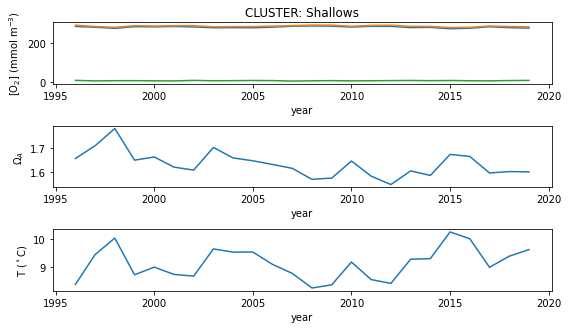

In [6]:
# Plot timeseries of all the relevant variables

timeseries_vars = [
    'O2',
    'OmegaA',
    'T',
    # 'ALK_norm',
    # 'DIC_norm',
    # 'ALK',
    # 'DIC',
]


long_names = dict(
    O2=r"$[\mathrm{O}_2]$",
    OmegaA="$\Omega_A$",
    T="T"
    # ALK_norm="Normalized Alkalinity",
    # DIC_norm="Normalized DIC",
    # ALK="Alkalinity",
    # DIC="DIC",
)

units = dict(
    O2="mmol m$^{-3}$",
    OmegaA="(non-dimensional)",
    T="$^\circ$C",
    
    # ALK_norm="mmolk m$^{-3}$",
    # DIC_norm="mmolk m$^{-3}$",
    # ALK="mmolk m$^{-3}$",
    # DIC="mmolk m$^{-3}$"
)


for cluster_label, cluster_ds in enumerate(clusters_ds):
    if cluster_label in plot_clusters:
        plt.figure(figsize=(8,10))    
        for idx, var in enumerate(timeseries_vars):        
            plt.subplot(7,1,idx+1)
            cluster_ds[var].groupby('time.year').mean('time').mean('stacked_y_x').plot()
            if var =='O2':
                (cluster_ds[var].groupby('time.year').mean('time').mean('stacked_y_x')+cluster_ds['AOU'].groupby('time.year').mean('time').mean('stacked_y_x')).plot()
                cluster_ds['AOU'].groupby('time.year').mean('time').mean('stacked_y_x').plot()
            if var=='OmegaA':
                plt.ylabel(f"{long_names[var]}")
            else:
                plt.ylabel(f"{long_names[var]} ({units[var]})")
            if idx == 0:
                plt.title(f'CLUSTER: '+ cluster_names[cluster_label])# {cluster_label}')
            else:
                plt.title('')
plt.tight_layout()   

### Correlations
Now, lets create look at the correlations between these time series and MEIv2 - the ENSO index. 

In [7]:
#load MEIv2
data=[]; count=0
with open('/gpfs/fs7/dfo/hpcmc/pfm/amh001/DATA/Climate-Indices/meiv2.data') as f:
    for line in f.readlines():
        l1=line.strip()
        l2=l1.split()
        try:
            #print(l2)
            year=int(l2[0])
            #print(year)
            if (year >1995) & (year<2020):
                #print(year)
                count=count+1
                dat=[float(num) for num in l2[1:]]
                #print(len(dat))
                
                data.extend(dat)
        except:
            print('exception', l2)
data =np.array(data)
dates=np.array(pd.date_range(start="1996-01-01",end="2019-12-01", freq=pd.DateOffset(months=1)))
# we use the beginning of the month because they are 2 month averages
#print(np.shape(data),np.shape(dates), dates[-1], dates[0], 12*(2020-1996))#

exception ['-999.00']
exception ['Multivariate', 'ENSO', 'Index', 'Version', '2', '(MEI.v2)']
exception ['https://www.psl.noaa.gov/enso/mei']
exception ['Row', 'values', 'are', '2', 'month', 'seasons', '(YEAR', 'DJ', 'JF', 'FM', 'MA', 'AM', 'MJ', 'JJ', 'JA', 'AS', 'SO', 'ON', 'ND)']


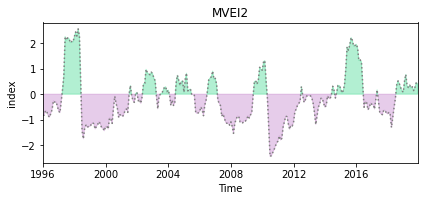

In [8]:
fig1=plt.figure(figsize=(6,5))
ax1=fig1.add_subplot(212)
plt.title('MVEI2')

plt.plot( dates,data, color='0.5', linestyle=':')
ax1.fill_between( dates,data,np.zeros(len(data)),where= data<0,color=color2, alpha=0.3, interpolate=True)
ax1.fill_between( dates,data,np.zeros(len(data)),where= data>0,color=color1, alpha=0.3, interpolate=True)
plt.ylabel('index')
plt.xlabel('Time')
plt.xlim(min(dates), max(dates))
#ax1.fill_betweenx( -depth,np.ones(75)*num*kk,newV,where=V[kk,:]<=0,color=color4, alpha=0.3, interpolate=True)
plt.tight_layout()

## Shallows

In [9]:
def deseason(df):
    monthly=df.resample(time='1MS').mean()
    #data_month = df.resample('M', on=df.index).mean()
    seas=df.groupby('time.month').mean()
    monthly_des=monthly.values

    num=12
    #print(monthly_des.shape, seas.shape)
    ii0=0
    ii=12
    while ii <=len(monthly):  
        #print(ii0, ii)
        monthly_des[ii0:ii]=monthly_des[ii0:ii]-seas.values
        ii0=ii
        ii=ii+12
    monthly_des[-1]=monthly_des[-1]-seas.values[0]
    print(monthly)
    return monthly_des, monthly.time

In [10]:
def pearsonr_ci_dof(x,y,alpha):
    ''' calculate Pearson correlation along with the confidence interval using scipy and numpy
    Parameters
    ----------
    x, y : iterable object such as a list or np.array
      Input for correlation calculation
    alpha : float
      Significance level. 0.05 by default
    Returns
    -------
    r : float
      Pearson's correlation coefficient
    pval : float
      The corresponding p value
    lo, hi : float
      The lower and upper bound of confidence intervals
    '''
    #calculatethe effective sample size for dependent sampls using autocorrelation (Storch and zwiers)
    N=len(x)
    r1=acf(x, nlags=1)[-1]
    r2=acf(y, nlags=1)[-1]
    dof = N*(1.-(r1*r2))/(1.+(r1*r2))
    r, p = ss.pearsonr(x,y)
    r_z = np.arctanh(r)
    se = 1/np.sqrt(dof-1)
    z = ss.norm.ppf(1-alpha/2)
    lo_z, hi_z = r_z-z*se, r_z+z*se
    lo, hi = np.tanh((lo_z, hi_z))
    return r, p, lo, hi


def plot_correlations(sig1,sig2,t0,nTime,label, index):
    alpha=0.1 # %95 confidence interval
    nsig1 = sig1 - np.mean(sig1) # Demean sig1
    nsig2 = sig2 - np.mean(sig2) # Demean
    ccov = np.correlate(nsig1, nsig2, mode='full')
    ccor = ccov / (len(sig2) * np.std(sig1) * np.std(sig2))
    #print(ccor)
    nx=len(sig1)
    lags = np.arange(-nx + 1, nx) # so last value is nx - 1
    ################
    fig=plt.figure(figsize=(6,5))
    ax = fig.add_subplot(311)
    #ax.plot(t0, nsig1, 'b', label='obs')
    print(np.nanmax(sig1), np.nanmax(sig2))
    #.plot( dates,data, color='0.5', linestyle=':')
    ax.fill_between( t0, sig2,np.zeros(len(sig2)),where= sig2<0,color=color2, alpha=0.3, interpolate=True)
    ax.fill_between( t0, sig2,np.zeros(len(sig2)),where= sig2>0,color=color1, alpha=0.3, interpolate=True)
    ax.plot(t0, sig2, color='0.5', label=label)
    ax.set_ylabel(label, labelpad=15)
    ax.set_xlabel('Time (years)')
    plt.xlim([1996, 2020]) 
 
    #ax.set_ylim(-10, 10)
    #ax.legend(loc='upper right', fontsize='small', ncol=2)
    ax = fig.add_subplot(312)
    ax.fill_between( nTime, sig1,np.zeros(len(sig1)),where= sig1<0,color=color2, alpha=0.3, interpolate=True)
    ax.fill_between( nTime, sig1,np.zeros(len(sig1)),where= sig1>0,color=color1, alpha=0.3, interpolate=True)
    ax.plot(nTime, sig1, color='0.5', label=label)

    #plt.xlim([nTime[0], nTime[-1]])
    #ax.plot(nTime, sig1, color=color2, label='NEP36')
    ax.set_ylabel(index, labelpad=15)
    ax.set_xlabel('Time (years)')
    plt.xlim([1996, 2020]) 
    #ax.plot(t0, nsig2, 'r', label='PDO')
    #ax.set_ylim(-10, 10)
    #ax.legend(loc='upper right', fontsize='small', ncol=2)
    ax = fig.add_subplot(313)
    ax.plot(lags, ccor)
    #ax.plot(lags[len(sig1)], ccor[len(sig1)], 'ro')
    ax.annotate( 'corr= '+str(round(ccor[len(sig1)-1],2)),(-250,.23))# (lags[len(sig1)-1], 0))
    #ax.set_ylim(-1.1, 1.1)
    ax.set_ylabel('cross-correlation')
    ax.set_xlabel('lag (months)')
    plt.xlim([-18, 18])

    maxlag = lags[np.argmax(ccor)]
    minlag = lags[np.argmin(ccor)]
    maxcorr=np.max(ccor)
    
    print("max correlation is at lag %d" % maxlag, "with r = %f" % maxcorr)

    print("min correlation is at lag %d" % minlag , "with r = %f" % np.min(ccor))
    plt.tight_layout()
    
    r, p, lo, hi=pearsonr_ci_dof(nsig1,nsig2,alpha)
    print('The pearson R value is ',  r, ' and the p_value is ', p)
    #print('stat=%.3f, p=%.3f' % (stat, p))
    if p > 0.01:
        print('Probably independent based on pearson')
    else:
        print('Probably dependent based on pearson')
        
    print('With', 100*(1-alpha), '% confidence, the time series correlation is between ', lo, hi)   
    return r,p,lo,hi

In [11]:
dates_1d=np.array(pd.date_range(start="1996-01-01",end="2019-12-31", freq='1D'))
print(np.shape(dates_1d))

(8766,)


In [12]:
#set the times according to the decimal time. 
t0 = 1996#1997.0
dt = 1/12  # In years
N = len(data)
ts = np.arange(0, N) * dt + t0

In [13]:
r_sh=np.zeros([3,4])
lo_sh=r_sh.copy();hi_sh=r_sh.copy(); p_sh=r_sh.copy()

r_can=np.zeros([3,4])
lo_can=r_sh.copy();hi_can=r_can.copy(); p_can=r_can.copy()


O2
##################################
pickles/Upwelling_3_O2_corr.pickle
pickles/Downwelling_3_O2_corr.pickle
<xarray.DataArray 'O2' (time: 288)>
dask.array<stack, shape=(288,), dtype=float64, chunksize=(1,), chunktype=numpy.ndarray>
Coordinates:
    deptht   float32 0.5075
  * time     (time) datetime64[ns] 1996-01-01 1996-02-01 ... 2019-12-01
(288,) 287 288
2.55 0.10982514170916632
max correlation is at lag -1 with r = 0.331189
min correlation is at lag -61 with r = -0.171827
The pearson R value is  0.32011246730733406  and the p_value is  2.9228118611348475e-08
Probably dependent based on pearson
With 90.0 % confidence, the time series correlation is between  0.10127246605307975 0.5094035589943382
0.32011246730733406
OmegaA
##################################
pickles/Upwelling_3_OmegaA_corr.pickle
pickles/Downwelling_3_OmegaA_corr.pickle
<xarray.DataArray 'OmegaA' (time: 288)>
dask.array<stack, shape=(288,), dtype=float64, chunksize=(1,), chunktype=numpy.ndarray>
Coordinates:
    dep

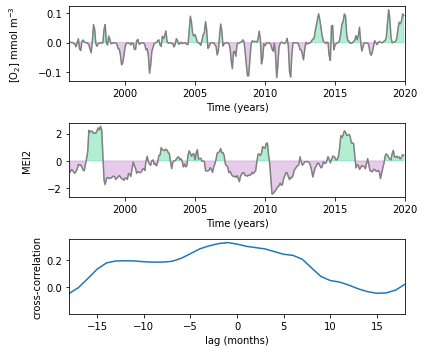

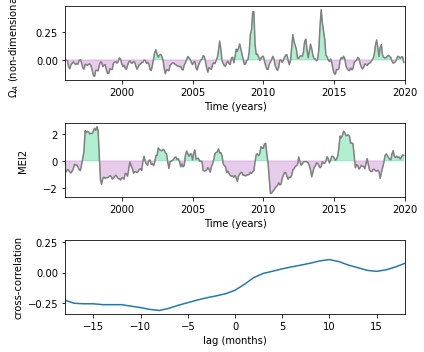

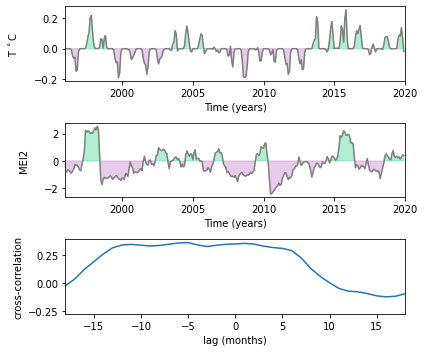

In [14]:
for idx, var in enumerate(timeseries_vars[:]):
    print(var)
    print('##################################')
    #ax = fig.add_subplot(3,1,idx+1)
    #fig, ax = plt.subplots(1,1, figsize = (Wf,Hf))
    for ii,label in enumerate(['Upwelling', 'Downwelling']):
        name0='pickles/'+label+'_3_'+var +'_corr.pickle'
        print(name0)
        with open(name0, 'rb') as fid:
            df = pickle.load(fid)
        #rint(df)
        #ax.scatter(df.time, df, label=label, s=2)
        if ii==0:
            upw=df   
        else:
            dwn=df
    merged_da = xr.merge([dwn,upw])
    X,time=deseason(merged_da[var])
    lm = len(X)
    bimon_SH = np.zeros([lm-1])
    for kk in np.arange(lm-1):
        #print(clim.values[kk:kk+2])
        bimon_SH[kk]=np.nanmean(X[kk:kk+2])
    print(np.shape(data), len(bimon_SH), len(ts))
    r,p,lo,hi=plot_correlations(data[1:],bimon_SH, ts[1:], ts[1:],  f"{long_names[var]} {units[var]}", 'MEI2')
    print(r)
    r_sh[idx,0]=r;p_sh[idx,0]=p;lo_sh[idx,0]=lo;hi_sh[idx,0]=hi
plt.savefig('NEP36_corr_frac_MEI2_omega_shallows.png', format='png', bbox_inches='tight',transparent=False,dpi=500)

In [15]:
len(X)

288

In [16]:
print(data)

[-0.83 -0.81 -0.64 -0.69 -0.83 -0.9  -0.76 -0.6  -0.26 -0.31 -0.3  -0.46
 -0.66 -0.72 -0.29  0.17  0.69  2.25  2.11  2.2   2.17  2.01  2.06  2.04
  2.23  2.43  2.27  2.55  2.26  0.37 -1.43 -1.74 -1.31 -1.21 -1.3  -1.25
 -1.26 -1.18 -1.11 -1.16 -1.36 -1.26 -1.18 -1.07 -1.17 -1.31 -1.33 -1.43
 -1.26 -1.27 -1.36 -0.93 -0.97 -1.14 -0.58 -0.08 -0.36 -0.55 -0.91 -0.8
 -0.82 -0.87 -0.79 -0.61 -0.58 -0.71 -0.01  0.34 -0.07 -0.25 -0.32  0.02
  0.07 -0.26 -0.2  -0.36 -0.1   0.4   0.42  0.97  0.84  0.79  0.76  0.86
  0.8   0.62  0.53 -0.08 -0.57 -0.07  0.    0.02  0.14  0.26  0.29  0.1
  0.16 -0.04 -0.44 -0.23 -0.44 -0.34  0.43  0.74  0.54  0.34  0.51  0.51
  0.08  0.6   0.82  0.13  0.18  0.2  -0.02 -0.01 -0.05 -0.71 -0.75 -0.73
 -0.68 -0.5  -0.62 -0.84 -0.43 -0.23  0.11  0.56  0.63  0.68  0.9   0.59
  0.62  0.39 -0.22 -0.36 -0.44 -0.86 -0.77 -0.94 -1.1  -1.14 -1.12 -1.21
 -1.08 -1.27 -1.53 -1.13 -0.98 -0.86 -0.87 -1.08 -1.07 -1.12 -1.04 -1.05
 -1.   -0.84 -0.93 -0.81 -0.72 -0.06  0.49  0.52  0.3

O2
##################################
<xarray.DataArray 'O2' (time: 288)>
dask.array<stack, shape=(288,), dtype=float64, chunksize=(1,), chunktype=numpy.ndarray>
Coordinates:
    deptht   float32 0.5075
  * time     (time) datetime64[ns] 1996-01-01 1996-02-01 ... 2019-12-01
2.55 0.2555663086287973
max correlation is at lag -42 with r = 0.225177
min correlation is at lag -9 with r = -0.491759
The pearson R value is  -0.21618902715999283  and the p_value is  0.00022405608999685904
Probably dependent based on pearson
With 90.0 % confidence, the time series correlation is between  -0.5022839049147563 0.11256727956152543
-0.21618902715999283
OmegaA
##################################
<xarray.DataArray 'OmegaA' (time: 288)>
dask.array<stack, shape=(288,), dtype=float64, chunksize=(1,), chunktype=numpy.ndarray>
Coordinates:
    deptht   float32 0.5075
  * time     (time) datetime64[ns] 1996-01-01 1996-02-01 ... 2019-12-01
2.55 0.2998113856080945
max correlation is at lag -42 with r = 0.266336


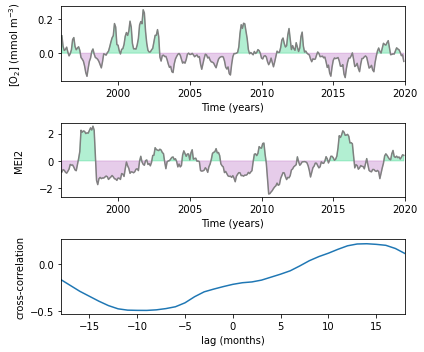

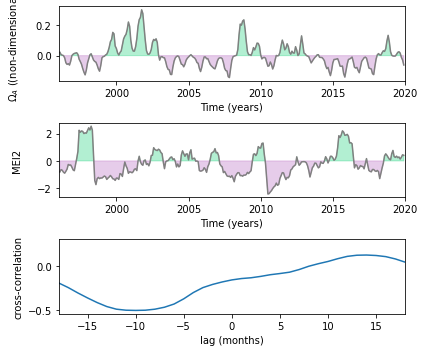

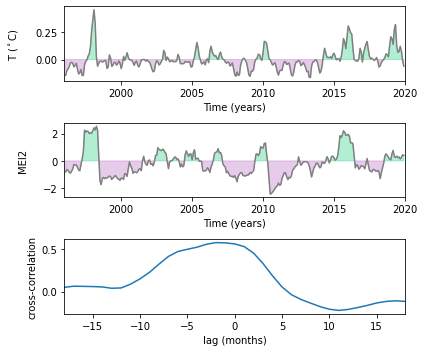

In [17]:
for idx, var in enumerate(timeseries_vars):
    print(var)
    print('##################################')
    #ax = fig.add_subplot(3,1,idx+1)
    #fig, ax = plt.subplots(1,1, figsize = (Wf,Hf))
    for ii,label in enumerate(['Upwelling', 'Downwelling']):
        name0='pickles/'+label+'_0_'+var +'_corr.pickle'
        with open(name0, 'rb') as fid:
            df = pickle.load(fid)
        #print(df.values)
        #ax.scatter(df.time, df, label=label, s=2)
        if ii==0:
            upw=df
            
        else:
            dwn=df
    merged_da = xr.merge([dwn,upw])
    X,time=deseason(merged_da[var])
    lm = len(X)
    bimon_SH = np.zeros([lm-1])
    for kk in np.arange(lm-1):
        #print(clim.values[kk:kk+2])
        bimon_SH[kk]=np.nanmean(X[kk:kk+2])
    r,p,lo,hi=plot_correlations(data[1:],bimon_SH, ts[1:], ts[1:],  f"{long_names[var]} ({units[var]})", 'MEI2')
    print(r)
    r_can[idx,0]=r;p_can[idx,0]=p;lo_can[idx,0]=lo;hi_can[idx,0]=hi
plt.savefig('NEP36_corr_frac_MEI2_omega_canyons.png', format='png', bbox_inches='tight',transparent=False,dpi=500)

### NPGO

exception could not convert string to float: '</pre>'
exception list index out of range
exception list index out of range
exception list index out of range
exception list index out of range
exception list index out of range
exception could not convert string to float: '</body></html>'
1996-01-15T00:00:00.000000000 2019-12-15T00:00:00.000000000 (288,) (288,)


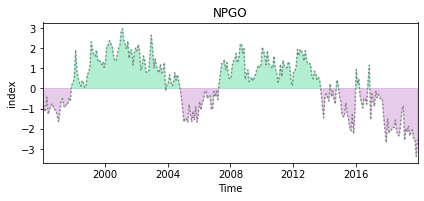

In [18]:
data=[]; count=0
with open('/gpfs/fs7/dfo/hpcmc/pfm/amh001/DATA/Climate-Indices/npgo.txt') as f:
    for line in f.readlines():
        l1=line.strip()
        l2=l1.split()
        count=count+1
        if count>30:
            try:
                #print(l2[0])
                year=int(float(l2[0]))
                #print(year)
                if (year >1995) & (year<2020):
                    #print(year)
                    #count=count+1
                    dat=float(l2[2])
                    #print((dat))

                    data.append(dat)
                    #print(data)
            except Exception as ex:
                print('exception', ex)
data =np.array(data)
dates=np.array(pd.date_range(start="1996-01-15",end="2020-01-01",freq=pd.DateOffset(months=1)))
print(dates[0], dates[-1],np.shape(dates) , np.shape(data))

fig1=plt.figure(figsize=(6,5))
ax1=fig1.add_subplot(212)
plt.title('NPGO')

plt.plot( dates,data, color='0.5', linestyle=':')
ax1.fill_between( dates,data,np.zeros(len(data)),where= data<0,color=color2, alpha=0.3, interpolate=True)
ax1.fill_between( dates,data,np.zeros(len(data)),where= data>0,color=color1, alpha=0.3, interpolate=True)
plt.ylabel('index')
plt.xlabel('Time')
plt.xlim(min(dates), max(dates))
#ax1.fill_betweenx( -depth,np.ones(75)*num*kk,newV,where=V[kk,:]<=0,color=color4, alpha=0.3, interpolate=True)
plt.tight_layout()

O2
##################################
<xarray.DataArray 'O2' (time: 288)>
dask.array<stack, shape=(288,), dtype=float64, chunksize=(1,), chunktype=numpy.ndarray>
Coordinates:
    deptht   float32 0.5075
  * time     (time) datetime64[ns] 1996-01-01 1996-02-01 ... 2019-12-01
2.9560468 0.15218352054065892
max correlation is at lag 84 with r = 0.163093
min correlation is at lag -1 with r = -0.412630
The pearson R value is  -0.3726033111677946  and the p_value is  6.467100905929571e-11
Probably dependent based on pearson
With 90.0 % confidence, the time series correlation is between  -0.5031260631685759 -0.225461270211483
OmegaA
##################################
<xarray.DataArray 'OmegaA' (time: 288)>
dask.array<stack, shape=(288,), dtype=float64, chunksize=(1,), chunktype=numpy.ndarray>
Coordinates:
    deptht   float32 0.5075
  * time     (time) datetime64[ns] 1996-01-01 1996-02-01 ... 2019-12-01
2.9560468 0.6390390936523335
max correlation is at lag -121 with r = 0.209914
min correlati

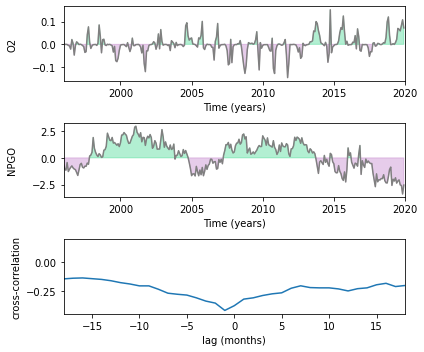

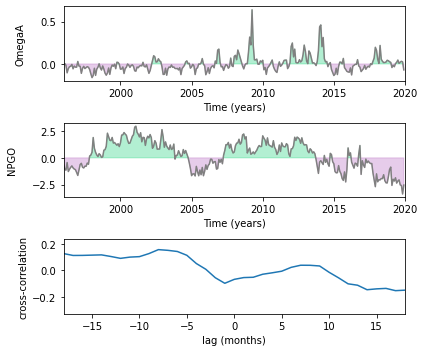

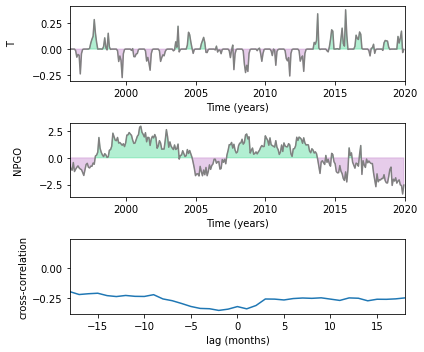

In [19]:
for idx, var in enumerate(timeseries_vars):
    print(var)
    print('##################################')
    #ax = fig.add_subplot(3,1,idx+1)
    #fig, ax = plt.subplots(1,1, figsize = (Wf,Hf))
    for ii,label in enumerate(['Upwelling', 'Downwelling']):
        name0='pickles/'+label+'_3_'+var +'_corr.pickle'
        with open(name0, 'rb') as fid:
            df = pickle.load(fid)
        #print(df.values)
        #ax.scatter(df.time, df, label=label, s=2)
        if ii==0:
            upw=df
            
        else:
            dwn=df
    merged_da = xr.merge([dwn,upw])
    X,time=deseason(merged_da[var])
    X_SH=X
    r,p,lo,hi=plot_correlations(data,X_SH, ts, ts, var, 'NPGO')
    r_sh[idx,2]=r;p_sh[idx,2]=p;lo_sh[idx,2]=lo;hi_sh[idx,2]=hi


O2
##################################
<xarray.DataArray 'O2' (time: 288)>
dask.array<stack, shape=(288,), dtype=float64, chunksize=(1,), chunktype=numpy.ndarray>
Coordinates:
    deptht   float32 0.5075
  * time     (time) datetime64[ns] 1996-01-01 1996-02-01 ... 2019-12-01
2.9560468 0.32049881360004795
max correlation is at lag -4 with r = 0.365142
min correlation is at lag -57 with r = -0.298200
The pearson R value is  0.2888603643020554  and the p_value is  6.115716020678299e-07
Probably dependent based on pearson
With 90.0 % confidence, the time series correlation is between  0.06300588727014787 0.4865691528854215
0.2888603643020554
OmegaA
##################################
<xarray.DataArray 'OmegaA' (time: 288)>
dask.array<stack, shape=(288,), dtype=float64, chunksize=(1,), chunktype=numpy.ndarray>
Coordinates:
    deptht   float32 0.5075
  * time     (time) datetime64[ns] 1996-01-01 1996-02-01 ... 2019-12-01
2.9560468 0.33440811118658476
max correlation is at lag -4 with r = 0.40

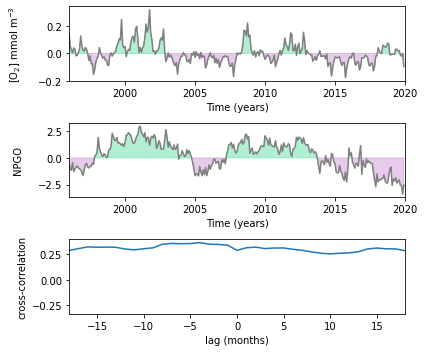

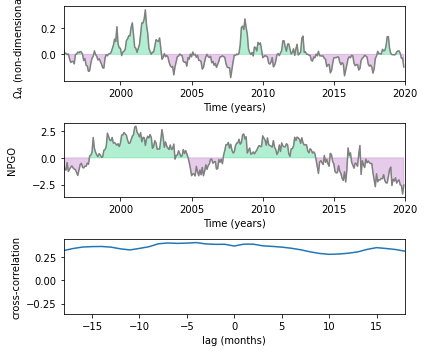

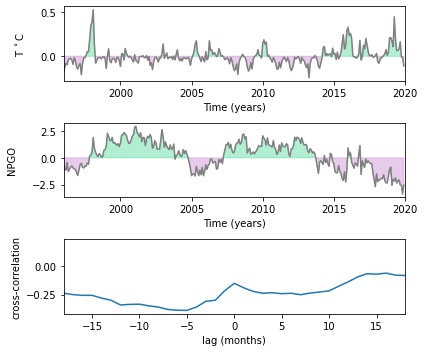

In [21]:
for idx, var in enumerate(timeseries_vars):
    print(var)
    print('##################################')
    #ax = fig.add_subplot(3,1,idx+1)
    #fig, ax = plt.subplots(1,1, figsize = (Wf,Hf))
    for ii,label in enumerate(['Upwelling', 'Downwelling']):
        name0='pickles/'+label+'_0_'+var +'_corr.pickle'
        with open(name0, 'rb') as fid:
            df = pickle.load(fid)
        #print(df.values)
        #ax.scatter(df.time, df, label=label, s=2)
        if ii==0:
            upw=df
            
        else:
            dwn=df
    merged_da = xr.merge([dwn,upw])
    X,time=deseason(merged_da[var])
    X_SH=X
    r,p,lo,hi=plot_correlations(data,X_SH, ts, ts, f"{long_names[var]} {units[var]}", 'NPGO')
    print(r)
    r_can[idx,2]=r;p_can[idx,2]=p;lo_can[idx,2]=lo;hi_can[idx,2]=hi
#plt.savefig('NEP36_corr_frac_NPGOO2.png', format='png', bbox_inches='tight',transparent=False,dpi=500)

In [ ]:
print(r_can)
print(r_sh)

### Bakun

In [22]:
data51=[]; count=0
with open('/gpfs/fs7/dfo/hpcmc/pfm/amh001/DATA/Climate-Indices/upind_51.txt') as f:
    for line in f.readlines():
        l1=line.strip()
        l2=l1.split()
        try:
            #print(l2)
            year=int(l2[2])
            #print(year)
            if (year >1995) & (year<2020):
                #print(year)
                count=count+1
                dat=[float(num) for num in l2[3:]]
                #print(len(dat))
                
                data51.extend(dat)
        except:
            print('exception', l2)
data =np.array(data51)
dates=np.array(pd.date_range(start="1996-01-01",end="2020-01-01", freq='M'))
#print(dates)


O2
##################################
<xarray.DataArray 'O2' (time: 288)>
dask.array<stack, shape=(288,), dtype=float64, chunksize=(1,), chunktype=numpy.ndarray>
Coordinates:
    deptht   float32 0.5075
  * time     (time) datetime64[ns] 1996-01-01 1996-02-01 ... 2019-12-01
103.0 0.15218352054065892
max correlation is at lag -1 with r = 0.172046
min correlation is at lag -46 with r = -0.210596
The pearson R value is  0.027006624300835586  and the p_value is  0.6480968557098173
Probably independent based on pearson
With 90.0 % confidence, the time series correlation is between  -0.09543594031833735 0.14864414946980475
OmegaA
##################################
<xarray.DataArray 'OmegaA' (time: 288)>
dask.array<stack, shape=(288,), dtype=float64, chunksize=(1,), chunktype=numpy.ndarray>
Coordinates:
    deptht   float32 0.5075
  * time     (time) datetime64[ns] 1996-01-01 1996-02-01 ... 2019-12-01
103.0 0.6390390936523335
max correlation is at lag -2 with r = 0.240969
min correlation is a

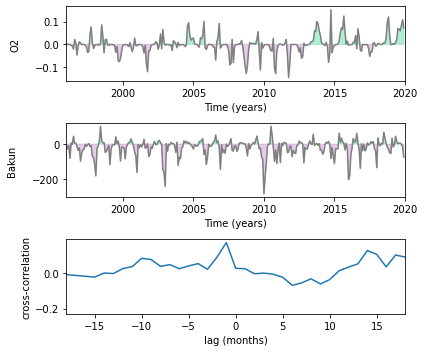

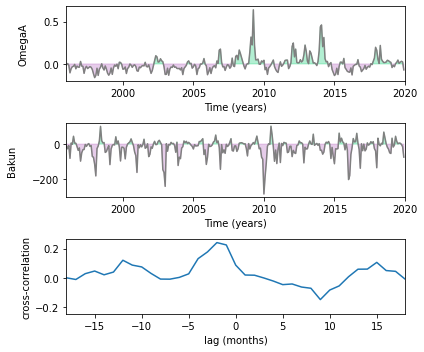

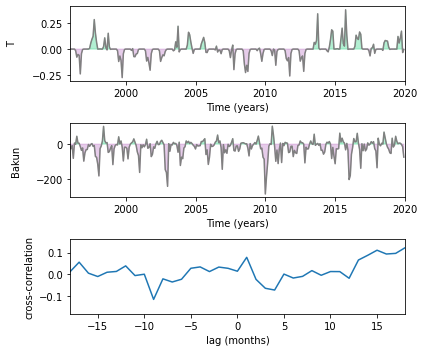

In [24]:
for idx, var in enumerate(timeseries_vars):
    print(var)
    print('##################################')
    #ax = fig.add_subplot(3,1,idx+1)
    #fig, ax = plt.subplots(1,1, figsize = (Wf,Hf))
    for ii,label in enumerate(['Upwelling', 'Downwelling']):
        name0='pickles/'+label+'_3_'+var +'_corr.pickle'
        with open(name0, 'rb') as fid:
            df = pickle.load(fid)
        #print(df.values)
        #ax.scatter(df.time, df, label=label, s=2)
        if ii==0:
            upw=df
            
        else:
            dwn=df
    merged_da = xr.merge([dwn,upw])
    X,time=deseason(merged_da[var])
    X_SH=X
    r,p,lo,hi=plot_correlations(data,X_SH, ts, ts, var, 'Bakun')
    r_sh[idx,3]=r;p_sh[idx,3]=p;lo_sh[idx,3]=lo;hi_sh[idx,3]=hi

O2
##################################
<xarray.DataArray 'O2' (time: 288)>
dask.array<stack, shape=(288,), dtype=float64, chunksize=(1,), chunktype=numpy.ndarray>
Coordinates:
    deptht   float32 0.5075
  * time     (time) datetime64[ns] 1996-01-01 1996-02-01 ... 2019-12-01
103.0 0.32049881360004795
max correlation is at lag -81 with r = 0.113519
min correlation is at lag 15 with r = -0.209185
The pearson R value is  0.09279615475045065  and the p_value is  0.11610219034894209
Probably independent based on pearson
With 90.0 % confidence, the time series correlation is between  -0.04600625840090899 0.22808321277358548
0.09279615475045065
OmegaA
##################################
<xarray.DataArray 'OmegaA' (time: 288)>
dask.array<stack, shape=(288,), dtype=float64, chunksize=(1,), chunktype=numpy.ndarray>
Coordinates:
    deptht   float32 0.5075
  * time     (time) datetime64[ns] 1996-01-01 1996-02-01 ... 2019-12-01
103.0 0.33440811118658476
max correlation is at lag -58 with r = 0.11312

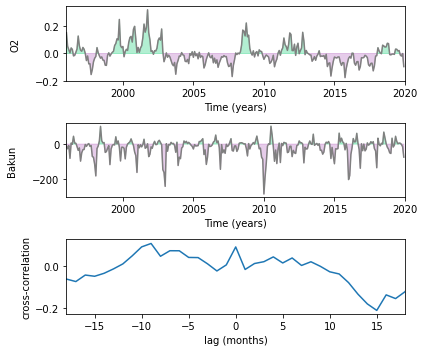

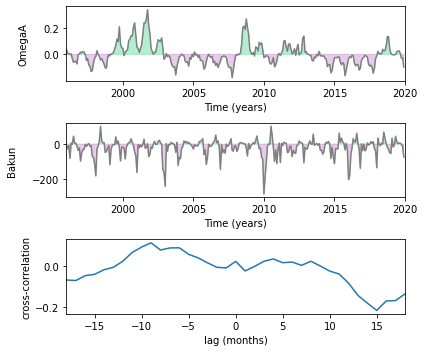

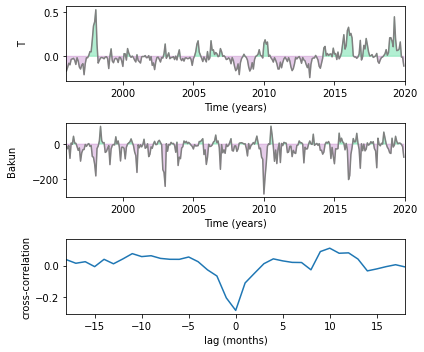

In [25]:
for idx, var in enumerate(timeseries_vars):
    print(var)
    print('##################################')
    #ax = fig.add_subplot(3,1,idx+1)
    #fig, ax = plt.subplots(1,1, figsize = (Wf,Hf))
    for ii,label in enumerate(['Upwelling', 'Downwelling']):
        name0='pickles/'+label+'_0_'+var +'_corr.pickle'
        with open(name0, 'rb') as fid:
            df = pickle.load(fid)
        #print(df.values)
        #ax.scatter(df.time, df, label=label, s=2)
        if ii==0:
            upw=df
            
        else:
            dwn=df
    merged_da = xr.merge([dwn,upw])
    X,time=deseason(merged_da[var])
    X_can=X
    r,p,lo,hi=plot_correlations(data,X_can, ts, ts, var, 'Bakun')
    print(r)
    r_can[idx,3]=r;p_can[idx,3]=p;lo_can[idx,3]=lo;hi_can[idx,3]=hi

## PDO

In [26]:
df = pd.read_csv ('/gpfs/fs7/dfo/hpcmc/pfm/amh001/DATA/Climate-Indices/pdo.timeseries.ersstv5.csv')
Time=df.Date.values
PDO=df.PDO.values
TIME = [datetime.datetime.strptime(t0,'%Y-%m-%d') for t0 in Time] 
print(TIME[12*142], TIME[-37], np.shape(TIME), np.shape(PDO))
dates=TIME[12*142:-36]
data=PDO[12*142:-36]

1996-01-01 00:00:00 2019-12-01 00:00:00 (2028,) (2028,)


O2
##################################
<xarray.DataArray 'O2' (time: 288)>
dask.array<stack, shape=(288,), dtype=float64, chunksize=(1,), chunktype=numpy.ndarray>
Coordinates:
    deptht   float32 0.5075
  * time     (time) datetime64[ns] 1996-01-01 1996-02-01 ... 2019-12-01
2.382 0.15218352054065892
max correlation is at lag 9 with r = 0.294942
min correlation is at lag -168 with r = -0.192271
The pearson R value is  0.1988924037165029  and the p_value is  0.0006872549398404532
Probably dependent based on pearson
With 90.0 % confidence, the time series correlation is between  0.04321848388831927 0.3451371573604531
OmegaA
##################################
<xarray.DataArray 'OmegaA' (time: 288)>
dask.array<stack, shape=(288,), dtype=float64, chunksize=(1,), chunktype=numpy.ndarray>
Coordinates:
    deptht   float32 0.5075
  * time     (time) datetime64[ns] 1996-01-01 1996-02-01 ... 2019-12-01
2.382 0.6390390936523335
max correlation is at lag -199 with r = 0.211586
min correlation is at

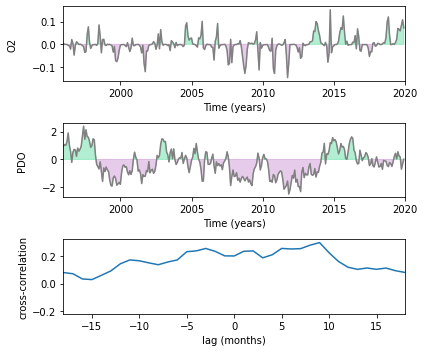

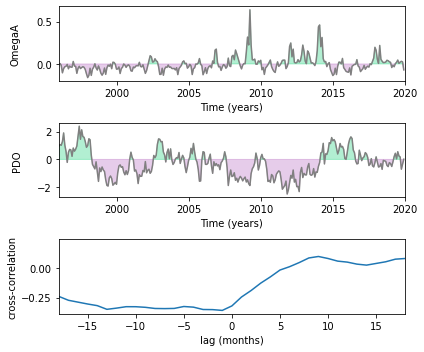

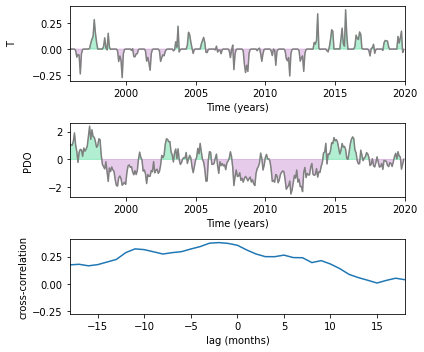

In [27]:
for idx, var in enumerate(timeseries_vars):
    print(var)
    print('##################################')
    #ax = fig.add_subplot(3,1,idx+1)
    #fig, ax = plt.subplots(1,1, figsize = (Wf,Hf))
    for ii,label in enumerate(['Upwelling', 'Downwelling']):
        name0='pickles/'+label+'_3_'+var +'_corr.pickle'
        with open(name0, 'rb') as fid:
            df = pickle.load(fid)
        #print(df.values)
        #ax.scatter(df.time, df, label=label, s=2)
        if ii==0:
            upw=df
            
        else:
            dwn=df
    merged_da = xr.merge([dwn,upw])
    X,time=deseason(merged_da[var])
    X_SH=X
    r,p,lo,hi=plot_correlations(data,X_SH, ts, ts, var,'PDO')
    r_sh[idx,1]=r;p_sh[idx,1]=p;lo_sh[idx,1]=lo;hi_sh[idx,1]=hi

##Canyons

O2
##################################
<xarray.DataArray 'O2' (time: 288)>
dask.array<stack, shape=(288,), dtype=float64, chunksize=(1,), chunktype=numpy.ndarray>
Coordinates:
    deptht   float32 0.5075
  * time     (time) datetime64[ns] 1996-01-01 1996-02-01 ... 2019-12-01
2.382 0.32049881360004795
max correlation is at lag -51 with r = 0.368930
min correlation is at lag -3 with r = -0.471261
The pearson R value is  -0.3607041990140213  and the p_value is  2.819974796004387e-10
Probably dependent based on pearson
With 90.0 % confidence, the time series correlation is between  -0.5370090434065873 -0.15420724070550196
-0.3607041990140213
OmegaA
##################################
<xarray.DataArray 'OmegaA' (time: 288)>
dask.array<stack, shape=(288,), dtype=float64, chunksize=(1,), chunktype=numpy.ndarray>
Coordinates:
    deptht   float32 0.5075
  * time     (time) datetime64[ns] 1996-01-01 1996-02-01 ... 2019-12-01
2.382 0.33440811118658476
max correlation is at lag -51 with r = 0.41483

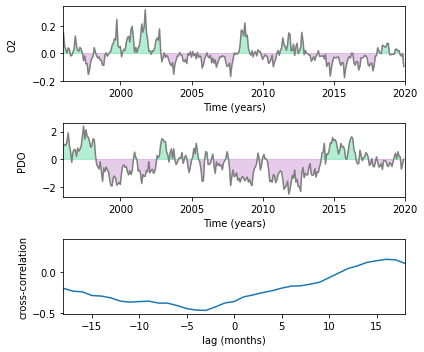

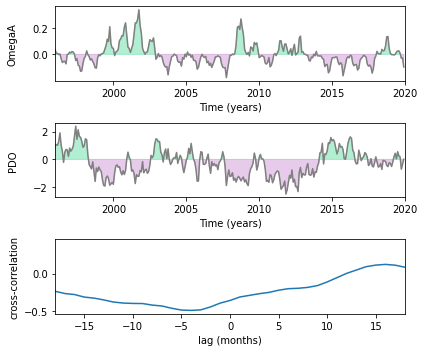

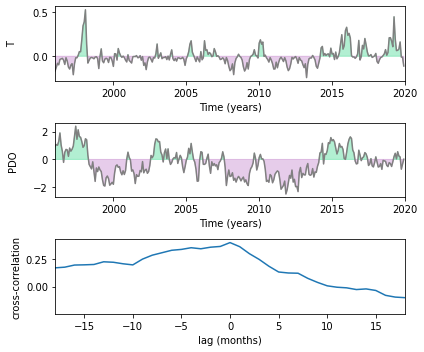

In [28]:
for idx, var in enumerate(timeseries_vars):
    print(var)
    print('##################################')
    #ax = fig.add_subplot(3,1,idx+1)
    #fig, ax = plt.subplots(1,1, figsize = (Wf,Hf))
    for ii,label in enumerate(['Upwelling', 'Downwelling']):
        name0='pickles/'+label+'_0_'+var +'_corr.pickle'
        with open(name0, 'rb') as fid:
            df = pickle.load(fid)
        #print(df.values)
        #ax.scatter(df.time, df, label=label, s=2)
        if ii==0:
            upw=df
            
        else:
            dwn=df
    merged_da = xr.merge([dwn,upw])
    X,time=deseason(merged_da[var])
    X_can=X
    r,p,lo,hi=plot_correlations(data,X_can, ts, ts, var, 'PDO')
    print(r)
    r_can[idx,1]=r;p_can[idx,1]=p;lo_can[idx,1]=lo;hi_can[idx,1]=hi

## HEATMAP Shallows


In [29]:
#from mpl_toolkits.axes_grid1.inset_locator import inset_axes

#mymap=sns.choose_diverging_palette(as_cmap=False)
r_can
r_sh

array([[ 0.32011247,  0.1988924 , -0.37260331,  0.02700662],
       [-0.14664899, -0.31960242, -0.06684775,  0.08750151],
       [ 0.35228017,  0.35388471, -0.31706476,  0.0145682 ]])

[[ 0.32011247  0.1988924  -0.37260331         nan]
 [        nan -0.31960242         nan         nan]
 [ 0.35228017  0.35388471 -0.31706476         nan]]


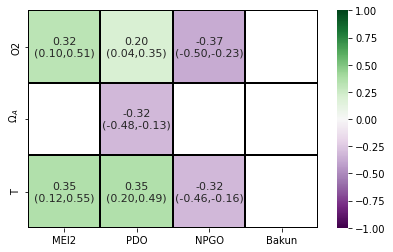

In [30]:
# combining text with values
formatted_text = (np.asarray(["{0:.2f}\n({1:.2f},{2:.2f})".format(
    B0,B1, B2) for B0,B1, B2 in zip(r_sh.flatten(), lo_sh.flatten(), hi_sh.flatten())])).reshape(3, 4)

cols=['MEI2', 'PDO', 'NPGO', 'Bakun']
rows=['O2','   $\Omega_A$', 'T']

R=r_sh.copy()

#eliminate p_values>0.01
R[p_sh>0.05]=np.nan
#remove values
IND = (hi_sh * lo_sh <0)

#IND=((hi_sh+lo_sh)<(np.abs(hi_sh)+np.abs(lo_sh)))
R[IND]=np.nan
figprops = dict(figsize=(7, 4))
fig = plt.figure(**figprops)
ax1 = fig.add_subplot(111)
print(R)
hm = sns.heatmap(R,
                 cbar=True,
                 annot=formatted_text,
                 square=True,
                 fmt='',
                 annot_kws={'size': 11},
                 cmap='PRGn',                 
                 yticklabels=rows,
                 xticklabels=cols, 
                linewidths=0.25, vmin=-1, vmax=1.0, linecolor='k')
#plt.savefig('Climate_indices_nobakun.jpg', format='jpg', bbox_inches='tight',transparent=False,dpi=150)

In [31]:
lo_sh

array([[ 0.10127247,  0.04321848, -0.50312606, -0.09543594],
       [-0.41772746, -0.48483322, -0.26658237, -0.04615552],
       [ 0.11813824,  0.20479148, -0.45784243, -0.10897591]])

In [32]:
r_sh

array([[ 0.32011247,  0.1988924 , -0.37260331,  0.02700662],
       [-0.14664899, -0.31960242, -0.06684775,  0.08750151],
       [ 0.35228017,  0.35388471, -0.31706476,  0.0145682 ]])

[[-0.21618903 -0.3607042   0.28886036  0.09279615]
 [-0.15541801 -0.36142479  0.3661909   0.02184345]
 [ 0.55663682  0.39681066 -0.1511732  -0.28694926]]


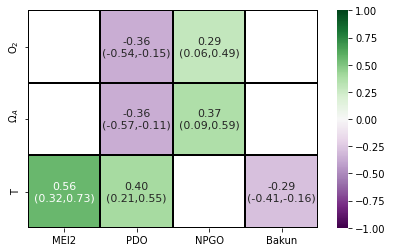

In [33]:
# combining text with values
formatted_text = (np.asarray(["{0:.2f}\n({1:.2f},{2:.2f})".format(
    B0,B1, B2) for B0,B1, B2 in zip(r_can.flatten(), lo_can.flatten(), hi_can.flatten())])).reshape(3, 4)

cols=['MEI2', 'PDO', 'NPGO', 'Bakun']
rows=['$\mathrm{O}_2$','   $\Omega_A$', 'T']
R=r_can.copy()
R[p_can>0.05]=np.nan
#remove values
IND = (hi_can * lo_can <0)

#IND=((hi_can+lo_can)<(np.abs(hi_can)+np.abs(lo_can)))
R[IND]=np.nan

figprops = dict(figsize=(7, 4))
fig = plt.figure(**figprops)
ax1 = fig.add_subplot(111)
print(r_can)
hm = sns.heatmap(R,
                 cbar=True,
                 annot=formatted_text,
                 square=True,
                 fmt='',
                 annot_kws={'size': 11},
                 cmap='PRGn',                 
                 yticklabels=rows,
                 xticklabels=cols, 
                linewidths=0.25, 
                 vmin=-1, vmax=1.0,
                linecolor='k')
#plt.savefig('Climate_indices_nobakun.jpg', format='jpg', bbox_inches='tight',transparent=False,dpi=150)

In [34]:
lo_can

array([[-0.5022839 , -0.53700904,  0.06300589, -0.04600626],
       [-0.48510113, -0.56964938,  0.0928313 , -0.12408022],
       [ 0.32079495,  0.21453503, -0.34783659, -0.40536546]])

In [35]:
hi_can

array([[ 0.11256728, -0.15420724,  0.48656915,  0.22808321],
       [ 0.21294877, -0.10960192,  0.5882165 ,  0.16684232],
       [ 0.72748337,  0.55237678,  0.05823277, -0.15906217]])

[[ 0.32011247  0.1988924  -0.37260331         nan]
 [        nan -0.31960242         nan         nan]
 [ 0.35228017  0.35388471 -0.31706476         nan]]


/tmp/ipykernel_157652/3218700906.py:77: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


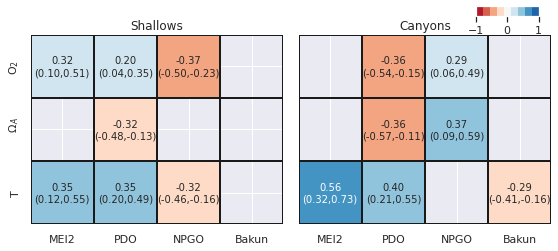

In [36]:
#import matplotlib.cm as cm
#from matplotlib import colors
#import colorcet as cc
sns.set()
cmap1 = mymap
# combining text with values
formatted_text = (np.asarray(["{0:.2f}\n({1:.2f},{2:.2f})".format(
    B0,B1, B2) for B0,B1, B2 in zip(r_sh.flatten(), lo_sh.flatten(), hi_sh.flatten())])).reshape(3, 4)

cols=['MEI2', 'PDO', 'NPGO', 'Bakun']
rows=['$\mathrm{O}_2$','   $\Omega_A$', 'T']

R=r_sh.copy()

#eliminate p_values>0.01
R[p_sh>0.05]=np.nan
#remove values
IND = (hi_sh * lo_sh <0)

#IND=((hi_sh+lo_sh)<(np.abs(hi_sh)+np.abs(lo_sh)))
R[IND]=np.nan
figprops = dict(figsize=(8, 5))
fig = plt.figure(**figprops)
ax1 = fig.add_subplot(121)
print(R)
hm = sns.heatmap(R,
                 cbar=False,
                 annot=formatted_text,
                    cbar_kws={'location': 'bottom', 'pad': 0.1},

                 square=True,
                 fmt='',
                 annot_kws={'size': 10},
                 cmap=cmap1,                 
                 yticklabels=rows,
                 xticklabels=cols, 
                linewidths=0.25, vmin=-1, vmax=1, linecolor='k')
plt.title('Shallows')

# combining text with values
formatted_text = (np.asarray(["{0:.2f}\n({1:.2f},{2:.2f})".format(
    B0,B1, B2) for B0,B1, B2 in zip(r_can.flatten(), lo_can.flatten(), hi_can.flatten())])).reshape(3, 4)

cols=['MEI2', 'PDO', 'NPGO', 'Bakun']
R=r_can.copy()
R[p_can>0.05]=np.nan
#remove values
IND = (hi_can * lo_can <0)

R[IND]=np.nan

ax2 = fig.add_subplot(122)
hm = sns.heatmap(R,
                 cbar=False,
                cbar_kws={'location': 'bottom', 'pad': 0.1},
                 annot=formatted_text,
                 square=True,
                 fmt='',
                 annot_kws={'size': 10},
                 cmap=cmap1,                 
                 yticklabels=[],
                 xticklabels=cols, 
                linewidths=0.25, 
                 vmin=-1, vmax=1,
                linecolor='k')
plt.title('Canyons')
axins = inset_axes(ax2,
                       width="100%",  # width = 5% of parent_bbox width
                       height="50%",  # height : 50%
                       loc='lower left',
                       bbox_to_anchor=(0.7, 1.1, 0.25, 0.1),
                       bbox_transform=ax2.transAxes,
                       borderpad=0,
                       )
#cbar=fig.colorbar(cs, cax=axins)
fig.colorbar(ax2.get_children()[0], cax=axins, orientation="horizontal")
plt.tight_layout()
#plt.savefig('NEP36_corr_frac.jpg', format='jpg', bbox_inches='tight',transparent=False,dpi=500)

[[ 0.32011247  0.1988924  -0.37260331         nan]
 [        nan -0.31960242         nan         nan]
 [ 0.35228017  0.35388471 -0.31706476         nan]]


/tmp/ipykernel_157652/1337995716.py:85: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


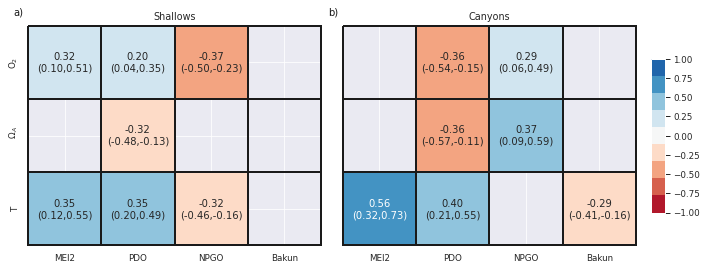

In [37]:
#import matplotlib.cm as cm
#from matplotlib import colors
#import colorcet as cc
#cmap1 = 'RdBu'
# combining text with values
sns.set('paper')
formatted_text = (np.asarray(["{0:.2f}\n({1:.2f},{2:.2f})".format(
    B0,B1, B2) for B0,B1, B2 in zip(r_sh.flatten(), lo_sh.flatten(), hi_sh.flatten())])).reshape(3, 4)

cols=['MEI2', 'PDO', 'NPGO', 'Bakun']
rows=['$\mathrm{O}_2$','   $\Omega_A$', 'T']

R=r_sh.copy()

#eliminate p_values>0.01
R[p_sh>0.01]=np.nan

lw=2
#remove values
IND = (hi_sh * lo_sh <0)

#IND=((hi_sh+lo_sh)<(np.abs(hi_sh)+np.abs(lo_sh)))
R[IND]=np.nan
figprops = dict(figsize=(Hf, Wf))
fig = plt.figure(**figprops)
ax1 = fig.add_subplot(121)
print(R)
hm = sns.heatmap(R,
                 cbar=False,
                 annot=formatted_text,
                    cbar_kws={'location': 'bottom', 'pad': 0.1},

                 square=True,
                 fmt='',
                 annot_kws={'size': 10},
                 cmap=mymap,                 
                 yticklabels=rows,
                 xticklabels=cols, 
                linewidths=lw, vmin=-1, vmax=1, linecolor='k', clip_on=False)
plt.title('Shallows')
ax1.text(-0.05, 1.05,'a)' , transform=ax1.transAxes, color='.1',size=10)


#################################
# combining text with values
formatted_text = (np.asarray(["{0:.2f}\n({1:.2f},{2:.2f})".format(
    B0,B1, B2) for B0,B1, B2 in zip(r_can.flatten(), lo_can.flatten(), hi_can.flatten())])).reshape(3, 4)

cols=['MEI2', 'PDO', 'NPGO', 'Bakun']
R=r_can.copy()
R[p_can>0.05]=np.nan
#remove values
IND = (hi_can * lo_can <0)

R[IND]=np.nan


ax2 = fig.add_subplot(122)
hm = sns.heatmap(R,
                 cbar=False,
                cbar_kws={'location': 'bottom', 'pad': 0.1},
                 annot=formatted_text,
                 square=True,
                 fmt='',
                 annot_kws={'size': 10},
                 cmap=cmap1,                 
                 yticklabels=[],
                 xticklabels=cols, 
                linewidths=lw, 
                 vmin=-1, vmax=1,
                linecolor='k', clip_on=False)
plt.title('Canyons')
axins = inset_axes(ax2,
                       width="50%",  # width = 5% of parent_bbox width
                       height="100%",  # height : 50%
                       loc='lower left',
                       bbox_to_anchor=(1.05, 0.15, 0.1, 0.7),
                       bbox_transform=ax2.transAxes,
                       borderpad=0,
                       )
ax2.text(-0.05, 1.05,'b)' , transform=ax2.transAxes, color='.1',size=10)

#cbar=fig.colorbar(cs, cax=axins)
fig.colorbar(ax2.get_children()[0], cax=axins, orientation="vertical")
plt.tight_layout()
plt.savefig('../Figures/NEP36_corr_frac.png', format='png', bbox_inches='tight',transparent=False,dpi=500)